## Decision tree

Linear model performed really poorly, also many of the numerical features did not follow a normal distribution even after log transformation. 

In this part, I want to try a decision tree, which is much more robust to non-normal distributions, so might perform better with less data preprocessing. 

In [1]:
path = './playground-series-s5e8'

In [2]:
import numpy as np, pandas as pd, os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./playground-series-s5e8/test.csv
./playground-series-s5e8/train.csv
./playground-series-s5e8/sample_submission.csv


In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Looking at the data

In [3]:
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(f'{path}/train.csv')
df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [5]:
df.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values (at least no NaNs).

## Continuous variables

In [6]:
df.describe(include='number')

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [7]:
df.y.unique()

array([0, 1])

```id``` is a unique value for each row/sample, so don't have to take that into consideration. ```y``` is the dependent variable.

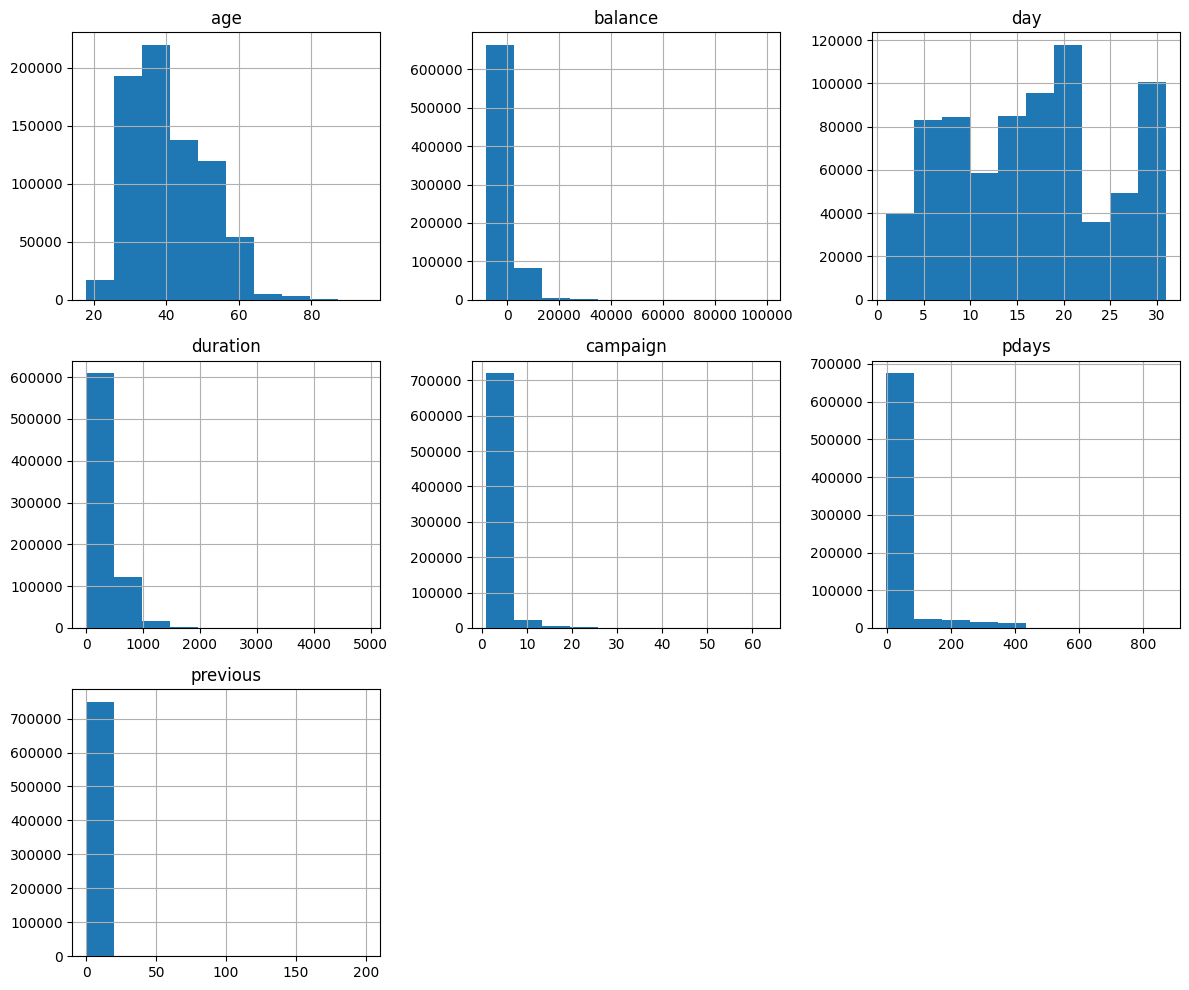

In [8]:
df_to_plot = df.select_dtypes(include='number').drop(columns=['id', 'y'])

df_to_plot.hist(figsize=(12,10));
plt.tight_layout()
plt.show()

In [9]:
df.pdays.value_counts()

pdays
-1      672434
 182      2515
 92       2275
 183      2074
 181      1698
         ...  
 647         1
 614         1
 420         1
 735         1
 20          1
Name: count, Length: 596, dtype: int64

## Categorical variables

In [10]:
df.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450


Looks like some of the categorical columns contain a category called 'unknown'. Specifically, the ```contact``` and ```poutcome``` columns contain this value.

In [11]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
cont = ['age','balance','day','duration','campaign','pdays','previous']
dep = 'y'

In [12]:
for col in cat_cols:
    print(df[col].unique())

['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur' 'self-employed' 'unknown' 'services' 'retired'
 'housemaid' 'unemployed']
['married' 'single' 'divorced']
['secondary' 'primary' 'tertiary' 'unknown']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['cellular' 'unknown' 'telephone']
['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']
['unknown' 'other' 'failure' 'success']


Instead of making dummy variables for the non-numeric columns, we will convert them into categorical variables, which encodes them as numbers:

In [13]:
def data_proc(df, cat_cols):
    for col in cat_cols:
        df[col] = df[col].astype('category')

In [14]:
data_proc(df, cat_cols)

Now, we have our predictor variables prepared. Converting them into PyTorch tensors now:

## Set up the data

Split data into train and validation sets. Then, I converted the categorical columns to their numerical codes.

In [15]:
from sklearn.model_selection import train_test_split

trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cat_cols] = trn_df[cat_cols].apply(lambda x: x.cat.codes)
val_df[cat_cols] = val_df[cat_cols].apply(lambda x: x.cat.codes)

In [16]:
def get_xs_y(df):
    xs = df[cat_cols+cont].copy()
    y = df[dep].copy() if dep in df else None
    return xs,y

trn_indep,trn_dep = get_xs_y(trn_df)
val_indep,val_dep = get_xs_y(val_df)

In [17]:
print(f'train: {len(trn_dep)}; validation: {len(val_dep)}') 

train: 562500; validation: 187500


## Creating a decision tree

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt = DecisionTreeClassifier(min_samples_leaf=1000).fit(trn_indep, trn_dep)

In [19]:
# import graphviz

# def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
#     s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
#                       special_characters=True, rotate=False, precision=precision, **kwargs)
#     return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

In [20]:
# draw_tree(dt, trn_indep, size=10)

In [21]:
from sklearn.metrics import mean_absolute_error, roc_auc_score

mean_absolute_error(val_dep, dt.predict(val_indep))

0.07744533333333334

In [22]:
roc_auc_score(val_dep, dt.predict(val_indep))

0.770674081000838

In [23]:
dt.predict_proba(val_indep)

array([[0.55682502, 0.44317498],
       [1.        , 0.        ],
       [0.64344942, 0.35655058],
       ...,
       [0.9872449 , 0.0127551 ],
       [1.        , 0.        ],
       [0.91531127, 0.08468873]])

In [24]:
dt.classes_

array([0, 1])

In [25]:
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(val_dep, preds)

# plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_scr:.3f}')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.grid()
# plt.show()

## Submitting to Kaggle

In [26]:
tst_df = pd.read_csv(f'{path}/test.csv')
tst_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown
249996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure
249997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success
249998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown


In [27]:
tst_df.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [28]:
data_proc(tst_df, cat_cols)

In [29]:
tst_df[cat_cols] = tst_df[cat_cols].apply(lambda x: x.cat.codes)

In [30]:
tst_indep,_ = get_xs_y(tst_df)

In [31]:
print(tst_indep.shape)

(250000, 16)


In [32]:
# function to create the submission csv
def subm(preds,suff):
    probs = np.stack(preds)[:,1]
    tst_df['y'] = probs
    sub_df = tst_df[['id','y']]
    sub_df.to_csv(f'sub_{suff}.csv', index=False)

In [33]:
subm(dt.predict_proba(tst_indep), 'dt')

In [34]:
!head sub_dt.csv

id,y
750000,0.0005446623093681918
750001,0.2995202193283071
750002,0.0033090668431502318
750003,0.0011389521640091116
750004,0.03218997361477573
750005,0.00199203187250996
750006,0.44534778681120146
750007,0.5599481529488011
750008,0.009328358208955223
